In [2]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import evaluations as ev
from utils import notebook_utils as nb



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1


    
    

def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir and 'tmp' not in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print(f"""{log_dir} \n snapshot_model_iter_{iters}""")
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))
    #model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_manager_iter_{}'.format(iters))))




def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered
    
def filter_list(query, mylist):
    filtered = [] 
    for key in mylist:
        if query in key:
            filtered.append(key)
    return filtered


def model_exists(targlist,  targpath):
    filtered_list = []
    for targdir in targlist:
        if os.path.exists(os.path.join(targpath, targdir, 'config.yml')):
            filtered_list.append(targdir)
    return filtered_list
    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

baseline_path = os.path.join(result_dir, '20220615_default_run_mnist')
basestar_path = os.path.join(result_dir, '20220615_NeuralMstar_neuralM_vanilla')
playground_path = os.path.join(result_dir, '20220913_playground_model')
print(baseline_path)
print(os.path.exists(baseline_path))
print(os.path.exists(basestar_path))
print(os.path.exists(playground_path))



filter_list('202209', os.listdir(result_dir))

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist
True
True
True


['20220901_Mstar_inv_reg_cnn_0',
 '20220908_lstsq_Mdetach_0',
 '20220909_latentPredict_zero_0',
 '20220908_latentPredict_bg_0',
 '20220901_Mstar_orth_0',
 '20220907_latentPredict_0',
 '20220913_default_run_again_0',
 '20220913_playground_model']

In [3]:
studypath = os.path.join(result_dir, '20220913_default_run_again_0')
logs = nb.read_log(studypath)

In [6]:
targdir_pathlist = []
targdir_pathlist.append(playground_path)
targdir_pathlist.append(basestar_path)
targdir_pathlist.append(baseline_path)
targdir_pathlist.append(studypath)

In [10]:
reload(ev)
output = ev.prediction_evalutation(targdir_pathlist, device =0,
                           n_cond=2, tp=8, repeats=3,
                           predictive=False,reconstructive = False)

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:01<00:00, 16.28it/s]


tensor([ 4.9035, 12.1649, 23.0596, 33.1332, 42.0969, 50.0244, 58.0282, 63.8972])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:01<00:00, 16.43it/s]


tensor([  5.9428,  39.0976,  71.7138,  83.2994,  90.1336,  97.4733, 106.0167,
        113.5949])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:01<00:00, 16.31it/s]


tensor([ 4.7215, 19.3984, 40.0383, 55.9845, 67.1882, 74.6724, 83.2575, 85.2004])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_default_run_again_0 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:01<00:00, 16.11it/s]


tensor([ 8.1483, 27.2024, 45.6822, 60.3445, 70.4970, 79.5941, 85.3990, 90.0370])


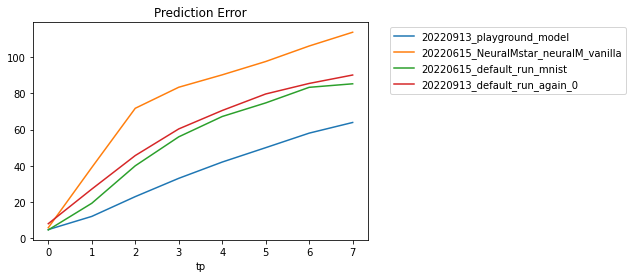

In [14]:
for mode in targdir_pathlist:
    plt.plot(output['results'][mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Prediction Error")

plt.savefig(os.path.join(studypath, 'l2loss.png'))
